## Data Exploration

We now have our data saved as a Corpus - represented as an array of dictionaries, each containing:
- notes: The pitch of a musical note (e.g., "C4", "E4").
- text: The tempo or style associated with the note (e.g., "animato", "allegro moderato").
- quarterBPM: The tempo in beats per minute (BPM), indicating the speed of the note.

Firstly, let's generate a MIDI file simply using the first 50 values in our corpus, to verify that we can read and write MIDI files.

In [ ]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:        
        # Adding the tempo
        tempoEvent = tempo.MetronomeMark(text=i['text'])
        tempoEvent.offset=offset
        Melody.append(tempoEvent)

        # Checking if the note is a chord, else it's a note
        note_or_chord = i['notes']
        if ("." in note_or_chord or note_or_chord.isdigit()):
            chord_notes = note_or_chord.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(note_or_chord)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:50])
Melody_Snippet.write('midi', "Generated.mid")


'Generated.mid'

And let's look at those 50 values in text-form:

In [ ]:
print("First fifty values in the Corpus:")
for item in Corpus[:50]:
    print(item)

First fifty values in the Corpus:
{'notes': 'C4', 'text': 'animato', 'quarterBPM': 119.51}
{'notes': 'E4', 'text': 'animato', 'quarterBPM': 121.51}
{'notes': 'E4', 'text': 'allegro moderato', 'quarterBPM': 127.01}
{'notes': 'C3', 'text': 'allegro moderato', 'quarterBPM': 127.01}
{'notes': 'G3', 'text': 'allegro moderato', 'quarterBPM': 127.01}
{'notes': 'C4', 'text': 'allegro moderato', 'quarterBPM': 127.01}
{'notes': 'E4', 'text': 'allegro moderato', 'quarterBPM': 127.01}
{'notes': 'G4', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'B3', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'C4', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'G4', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'F4', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'A3', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'C4', 'text': 'allegro moderato', 'quarterBPM': 128.01}
{'notes': 'F4', 'text': 'animato', 'quarterBPM': 119.51}
{'n

From this overview - it would seem like tempos are repeated a lot, which is to be expected. Let's look a bit into them anyways:

**Examining all the tempos in the Corpus:**

In [ ]:
#Creating a count dictionary
count_tempo = Counter([tuple(item['text']) for item in Corpus])
print("Total unique tempos in the Corpus:", len(count_tempo))

Total unique tempos in the Corpus: 15


So, we see that there is only 15 different tempos. How about BPM's?

In [ ]:
# Creating a count dictionary for unique BPM values
count_bpm = Counter([item['quarterBPM'] for item in Corpus])

# Print the total number of unique BPMs
print("Total unique BPM values in the Corpus:", len(count_bpm))

# Print each unique BPM and its count
print("Unique BPM values in the Corpus:")
for bpm, count in count_bpm.items():
    print(f"BPM: {bpm}, Count: {count}")

Total unique BPM values in the Corpus: 359
Unique BPM values in the Corpus:
BPM: 119.51, Count: 3
BPM: 121.51, Count: 1
BPM: 127.01, Count: 5
BPM: 128.01, Count: 7
BPM: 128.17, Count: 33
BPM: 126.74, Count: 74
BPM: 126.67, Count: 12
BPM: 127.67, Count: 17
BPM: 107.67, Count: 11
BPM: 107.57, Count: 2
BPM: 128.07, Count: 10
BPM: 121.73, Count: 9
BPM: 107.84, Count: 1
BPM: 127.29, Count: 2
BPM: 126.18, Count: 3
BPM: 108.95, Count: 1
BPM: 121.84, Count: 1
BPM: 92.84, Count: 1
BPM: 129.51, Count: 81
BPM: 131.18, Count: 11
BPM: 128.4, Count: 8
BPM: 128.96, Count: 3
BPM: 127.34, Count: 3
BPM: 70.27, Count: 1
BPM: 128.67, Count: 20
BPM: 126.17, Count: 6
BPM: 129.17, Count: 8
BPM: 120.67, Count: 4
BPM: 121.17, Count: 3
BPM: 119.07, Count: 2
BPM: 132.17, Count: 4
BPM: 131.67, Count: 1
BPM: 131.17, Count: 1
BPM: 130.67, Count: 2
BPM: 130.17, Count: 7
BPM: 129.67, Count: 3
BPM: 127.17, Count: 1
BPM: 107.77, Count: 7
BPM: 106.77, Count: 2
BPM: 82.77, Count: 2
BPM: 72.77, Count: 1
BPM: 109.27, Count

There is clearly a lot more unique BPM values than there are tempo-names. This again, makes perfect sense as the names each cover a range of BPMs.
We will now associate each unique name with the average of all BPMs associated with it.

In [ ]:
from collections import defaultdict

# Dictionary to store sum of BPM values and count for each tempo
tempo_bpm_data = defaultdict(lambda: {'sum': 0, 'count': 0})

# Populate the dictionary with cumulative BPM and counts
for item in Corpus:
    tempo = item['text']
    bpm = item['quarterBPM']
    tempo_bpm_data[tempo]['sum'] += bpm
    tempo_bpm_data[tempo]['count'] += 1

# Calculate the average BPM for each tempo
tempo_avg_bpm = {tempo: data['sum'] / data['count'] for tempo, data in tempo_bpm_data.items()}

# Print the results
print("Average BPM for each unique tempo:")
for tempo, avg_bpm in tempo_avg_bpm.items():
    print(f"Tempo: {tempo}, Average BPM: {avg_bpm:.2f}")


Average BPM for each unique tempo:
Tempo: animato, Average BPM: 120.34
Tempo: allegro moderato, Average BPM: 127.46
Tempo: allegretto, Average BPM: 108.11
Tempo: moderate, Average BPM: 92.36
Tempo: allegro, Average BPM: 132.07
Tempo: andante, Average BPM: 72.57
Tempo: andante moderato, Average BPM: 83.32
Tempo: allegrissimo, Average BPM: 139.63
Tempo: molto allegro, Average BPM: 143.28
Tempo: adagio, Average BPM: 55.12
Tempo: andantino, Average BPM: 80.30
Tempo: maestoso, Average BPM: 88.15
Tempo: larghetto, Average BPM: 60.02
Tempo: adagietto, Average BPM: 66.84
Tempo: lento, Average BPM: 53.16


We can see, that we have in total 15 different tempos in the Corpus. Let's look at their distribution:

In [ ]:
# Explore the tempos dictionary
tempos = list(count_tempo)
recurrence = list(count_tempo.values())

print("Average recurrence for a tempo in Corpus:", sum(recurrence) / len(recurrence))
print("Most frequent tempo in Corpus appeared:", max(recurrence), "times")
print("Least frequent tempo in Corpus appeared:", min(recurrence), "time")

Average recurrenc for a tempo in Corpus: 254.26666666666668
Most frequent tempo in Corpus appeared: 716 times
Least frequent tempo in Corpus appeared: 6 time


In [ ]:
# Explore the tempo_avg_bpm dictionary
tempos = list(tempo_avg_bpm.keys())  # List of unique tempos
average_bpms = list(tempo_avg_bpm.values())  # List of average BPMs

# Print summary statistics
print("Total unique tempos in Corpus:", len(tempos))
print("Average BPM across all tempos in Corpus:", sum(average_bpms) / len(average_bpms))
print("Tempo with the highest average BPM:", tempos[average_bpms.index(max(average_bpms))], "with", max(average_bpms), "BPM")
print("Tempo with the lowest average BPM:", tempos[average_bpms.index(min(average_bpms))], "with", min(average_bpms), "BPM")


Total unique tempos in Corpus: 15
Average BPM across all tempos in Corpus: 94.84922318478169
Tempo with the highest average BPM: molto allegro with 143.2832432432435 BPM
Tempo with the lowest average BPM: lento with 53.16166666666666 BPM


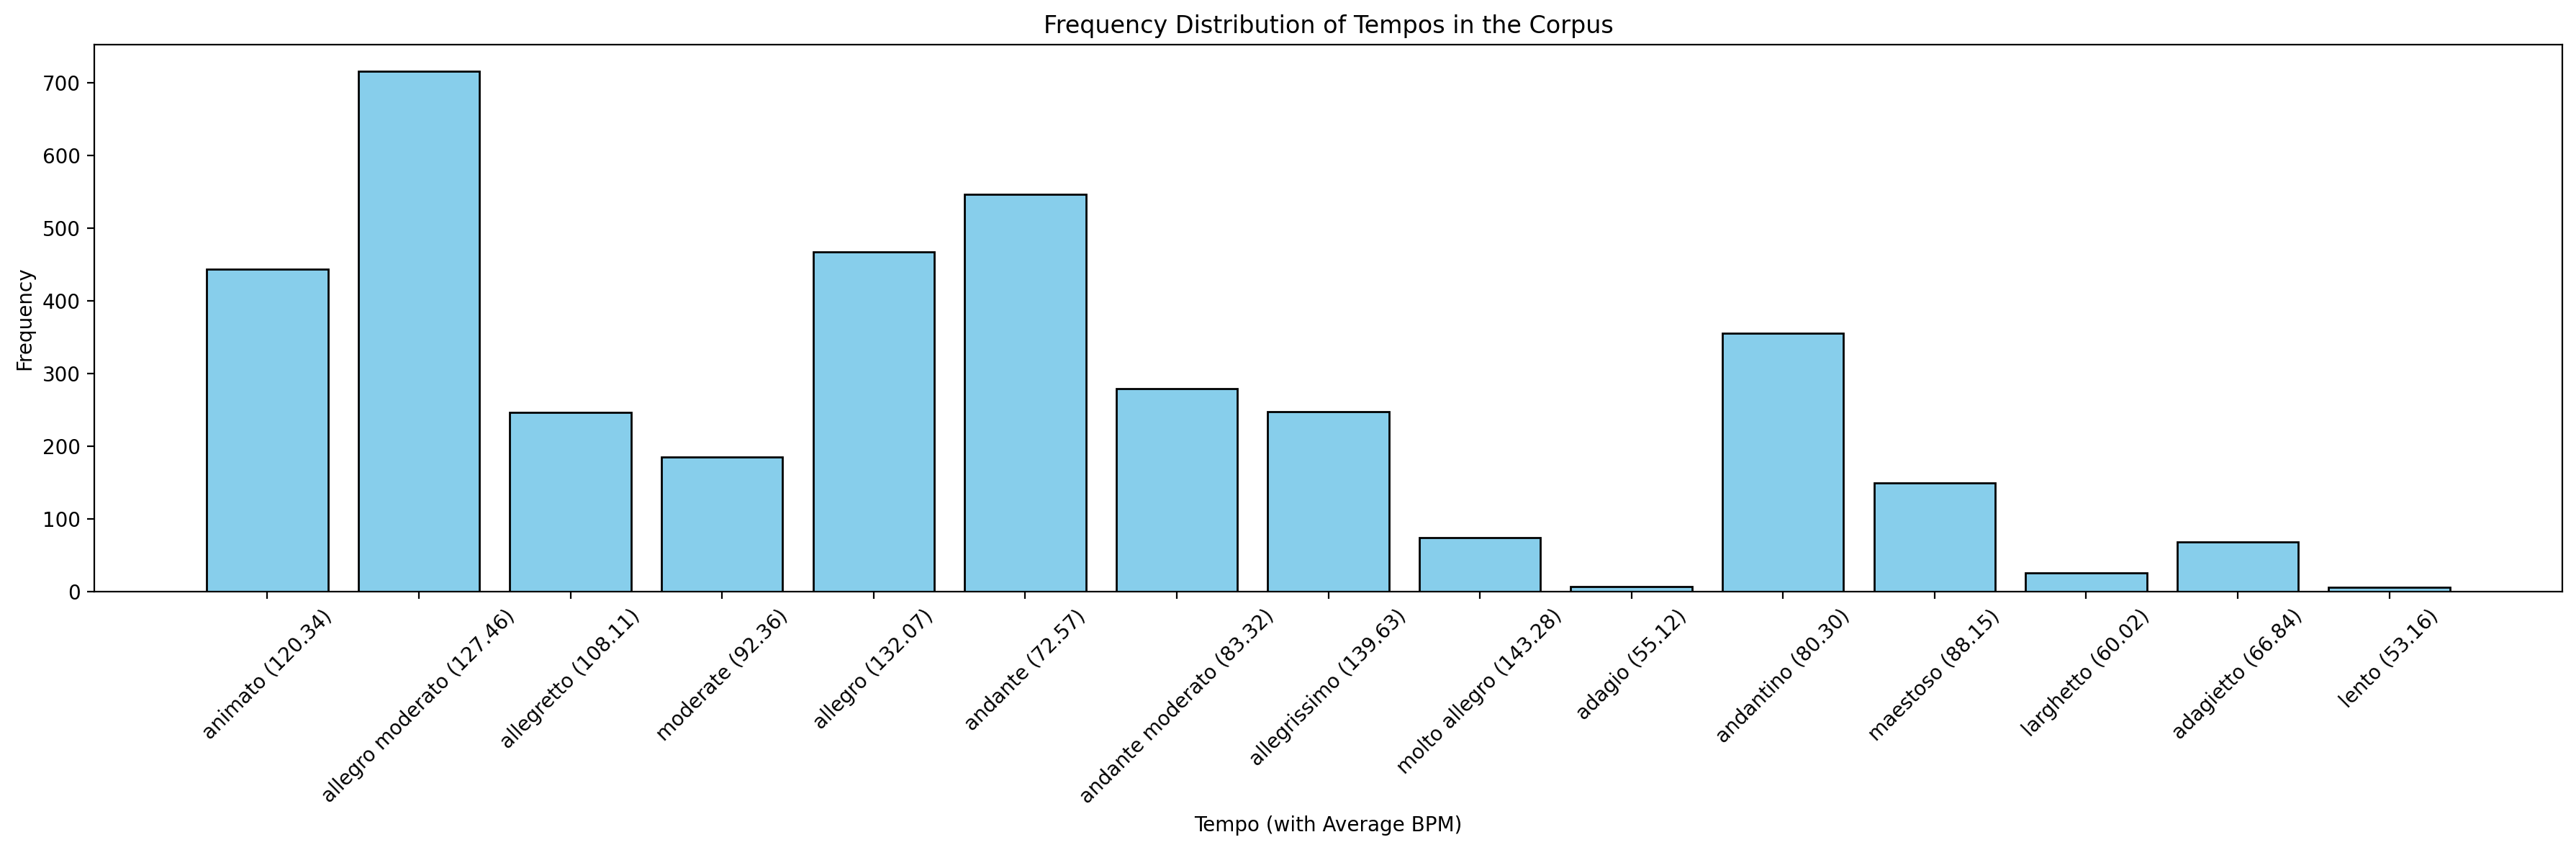

In [ ]:
import matplotlib.pyplot as plt

# Extract tempo names with average BPM in parentheses and their frequencies
tempo_labels = [f"{tempo} ({avg_bpm:.2f})" for tempo, avg_bpm in tempo_avg_bpm.items()]
tempo_frequencies = [tempo_bpm_data[tempo]['count'] for tempo in tempo_avg_bpm.keys()]

# Plot the histogram
plt.figure(figsize=(18, 6))
plt.bar(tempo_labels, tempo_frequencies, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Frequency Distribution of Tempos in the Corpus")
plt.xlabel("Tempo (with Average BPM)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()


The histogram shown above highlights the dominance of a few tempos in the set, with a long "tail" of rarer tempos contributing to the variety. This uneven distribution of tempos is typical of music in general, where a small number of widely preferred tempos overshadow more specialized or genre-specific ones.

**Examine all the notes in the Corpus** 

*NOTE: This part is left untouched from the project used for inspiration.*

In [ ]:
#Creating a count dictionary
count_num = Counter([tuple(item['notes']) for item in Corpus])
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 235


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 32.13191489361702
Most frequent note in Corpus appeared: 293 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

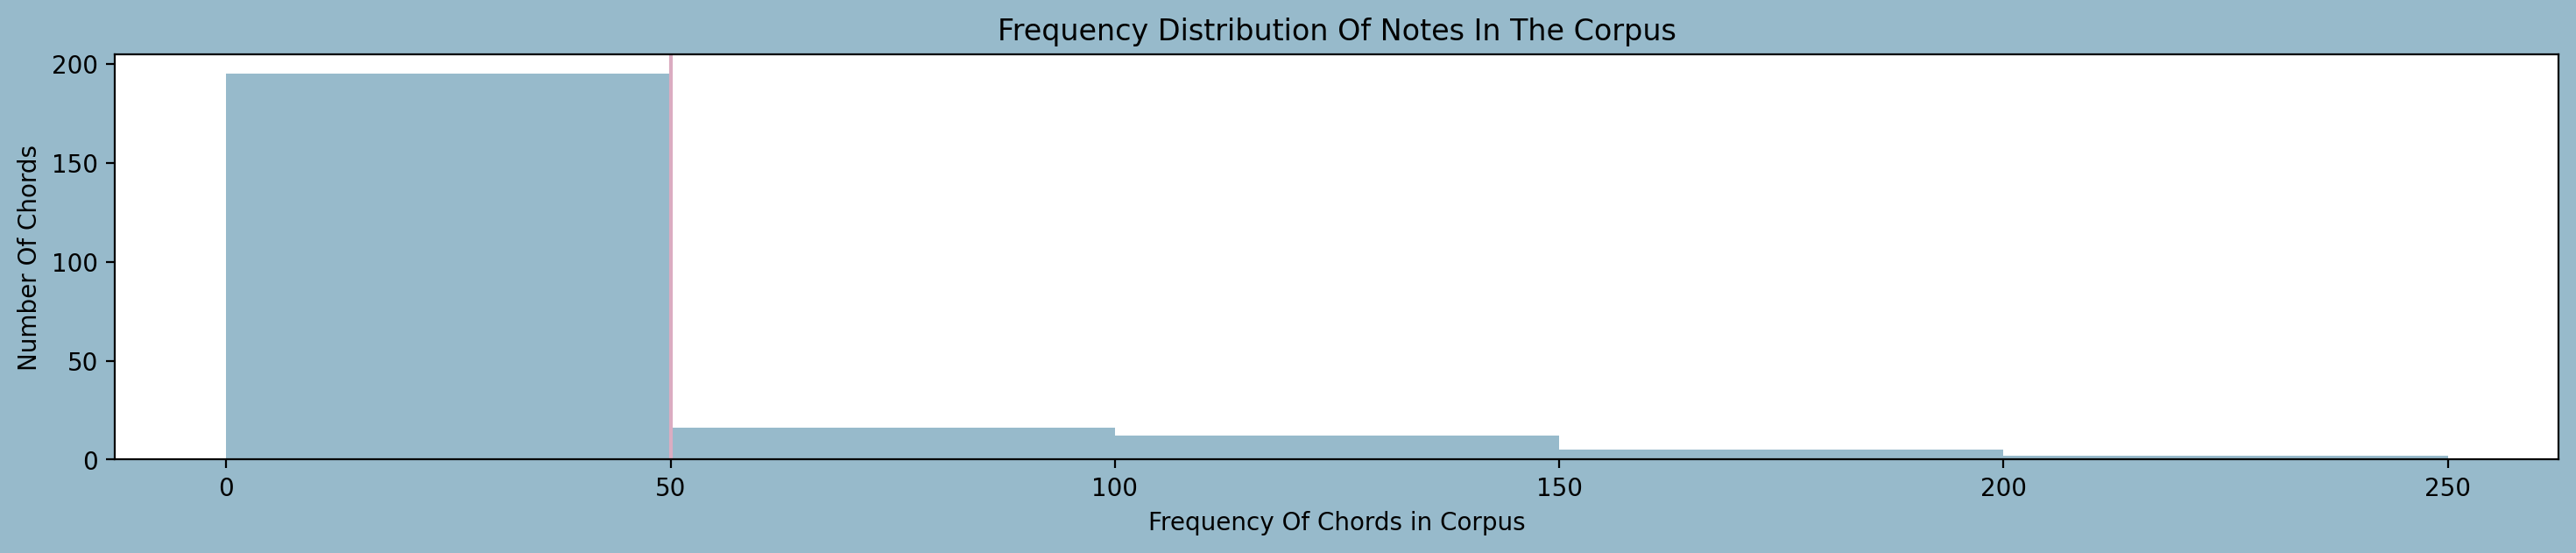

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=50,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 50:
        m =  ''.join(key)
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 195


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element['notes'] in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 6014
